In [3]:
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from fake_useragent import UserAgent

#### Часть 1. Парсинг

В качестве предмета для парсинга выбран, традиционно, ресурс фильмов и сериалов [IMDb](https://www.imdb.com/). Конкретно выбрана страница кинофильма ["Побег из Шоушенка"](https://www.imdb.com/title/tt0111161/reviews?ref_=tt_urv). Цель настоящей работы - оценить тональность отзывов по указанному фильму (~11000). Я понимаю, что тональность надо оценивать по всему корпусу фильмов. Но я сознательно выбрал один фильм, ввиду временных ограничений для выполнения процедуры парсинга. 

##### 1.1. Попытка парсинга №1

In [4]:
UserAgent().chrome

'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36'

In [5]:
response = requests.get('https://www.imdb.com/title/tt0111161/reviews?ref_=tt_urv', headers={'User-Agent': UserAgent().chrome})
response

<Response [200]>

In [6]:
html = response.content

In [7]:
html[:1000]

b'\n\n\n\n\n\n\n\n\n<!DOCTYPE html>\n<html\n    xmlns:og="http://ogp.me/ns#"\n    xmlns:fb="http://www.facebook.com/2008/fbml">\n    <head>\n        \n<script type=\'text/javascript\'>var ue_t0=ue_t0||+new Date();</script>\n<script type=\'text/javascript\'>\nwindow.ue_ihb = (window.ue_ihb || window.ueinit || 0) + 1;\nif (window.ue_ihb === 1) {\n\nvar ue_csm = window,\n    ue_hob = +new Date();\n(function(d){var e=d.ue=d.ue||{},f=Date.now||function(){return+new Date};e.d=function(b){return f()-(b?0:d.ue_t0)};e.stub=function(b,a){if(!b[a]){var c=[];b[a]=function(){c.push([c.slice.call(arguments),e.d(),d.ue_id])};b[a].replay=function(b){for(var a;a=c.shift();)b(a[0],a[1],a[2])};b[a].isStub=1}};e.exec=function(b,a){return function(){try{return b.apply(this,arguments)}catch(c){ueLogError(c,{attribution:a||"undefined",logLevel:"WARN"})}}}})(ue_csm);\n\n\n    var ue_err_chan = \'jserr\';\n(function(d,e){function h(f,b){if(!(a.ec>a.mxe)&&f){a.ter.push(f);b=b||{};var c=f.logLevel||b.logLevel;c&

In [8]:
len(html)

404787

In [9]:
type(html)

bytes

In [10]:
from bs4 import BeautifulSoup

In [11]:
soup = BeautifulSoup(html, 'html.parser')

In [32]:
reviews = soup.findAll(lambda tag: tag.name == 'div' and tag.get('class') == ['text', 'show-more__control'])

In [33]:
len(reviews)

25

In [30]:
#main > section > div.lister > div.lister-list > div:nth-child(2) > div.review-container > div.lister-item-content > div.ipl-ratings-bar > span > span:nth-child(2)
marks = soup.findAll(lambda tag: tag.name == 'div' and tag.get('class') == ['lister-item-content'])

In [31]:
len(marks)

25

Как видно, в лоб удалось распарсить только 25 отзывов. Причина понятна - кнопка **Load more**. Чтобы просмотреть следующие отзывы надо нажать эту кнопку. Суп давить кнопки не умеет. Выход - Selenium

##### 1.1. Попытка парсинга №2

In [40]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [41]:
executable_path = "C:\Program Files (x86)\chromedriver.exe"

chrome_service = webdriver.ChromeService(executable_path=executable_path)
driver = webdriver.Chrome(service = chrome_service)

driver.get("https://www.imdb.com/title/tt0111161/reviews?ref_=tt_urv")
driver.maximize_window()

In [68]:
for _ in range(0, 444):
    WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, "/html/body/div[2]/div/div[2]/div[3]/div[1]/section/div[2]/div[4]/div/button"))).click()

In [69]:
reviews = driver.find_elements(By.CSS_SELECTOR, '.text.show-more__control')

In [88]:
reviews[1]

<selenium.webdriver.remote.webelement.WebElement (session="5d5df0efa2337b6cd5f202e42dcef44d", element="f.8C65F882A7FDE70F58F745AB1D66E4C6.d.082A8325C0FF2557571CDAAB3D91A6C9.e.9411")>

In [70]:
len(reviews)

11077

In [71]:
reviews[1].text

"It is no wonder that the film has such a high rating, it is quite literally breathtaking. What can I say that hasn't said before? Not much, it's the story, the acting, the premise, but most of all, this movie is about how it makes you feel. Sometimes you watch a film, and can't remember it days later, this film loves with you, once you've seen it, you don't forget.\n\nThe ultimate story of friendship, of hope, and of life, and overcoming adversity.\n\nI understand why so many class this as the best film of all time, it isn't mine, but I get it. If you haven't seen it, or haven't seen it for some time, you need to watch it, it's amazing. 10/10."

In [94]:
data = []
for i in range(0, len(reviews)):
    data.append(reviews[i].text)

In [95]:
len(data)

11077

In [96]:
data[1]

"It is no wonder that the film has such a high rating, it is quite literally breathtaking. What can I say that hasn't said before? Not much, it's the story, the acting, the premise, but most of all, this movie is about how it makes you feel. Sometimes you watch a film, and can't remember it days later, this film loves with you, once you've seen it, you don't forget.\n\nThe ultimate story of friendship, of hope, and of life, and overcoming adversity.\n\nI understand why so many class this as the best film of all time, it isn't mine, but I get it. If you haven't seen it, or haven't seen it for some time, you need to watch it, it's amazing. 10/10."

In [72]:
marks = driver.find_elements(By.CLASS_NAME, 'lister-item-content')

In [73]:
len(marks)

11077

In [79]:
marks[1].get_attribute('innerHTML')

'\n    <div class="ipl-ratings-bar">\n            <span class="rating-other-user-rating">\n            <svg class="ipl-icon ipl-star-icon  " xmlns="http://www.w3.org/2000/svg" fill="#000000" height="24" viewBox="0 0 24 24" width="24">\n                <path d="M0 0h24v24H0z" fill="none"></path>\n                <path d="M12 17.27L18.18 21l-1.64-7.03L22 9.24l-7.19-.61L12 2 9.19 8.63 2 9.24l5.46 4.73L5.82 21z"></path>\n                <path d="M0 0h24v24H0z" fill="none"></path>\n            </svg>\n                <span>10</span><span class="point-scale">/10</span>\n            </span>\n    </div>\n<a href="/review/rw6606154/?ref_=tt_urv" class="title"> An incredible movie. One that lives with you.\n</a>            <div class="display-name-date">\n                    <span class="display-name-link"><a href="/user/ur15311310/?ref_=tt_urv">Sleepin_Dragon</a></span><span class="review-date">17 February 2021</span>\n            </div>\n            <div class="content">\n                <div 

In [81]:
labels = []
for i in range(0, len(marks)):
    if '<span>10</span>' in marks[i].get_attribute('innerHTML'):
        labels.append(1)
    elif '<span>9</span>' in marks[i].get_attribute('innerHTML'):
        labels.append(1)
    elif '<span>8</span>' in marks[i].get_attribute('innerHTML'):
        labels.append(1)
    elif '<span>7</span>' in marks[i].get_attribute('innerHTML'):
        labels.append(0)
    elif '<span>6</span>' in marks[i].get_attribute('innerHTML'):
        labels.append(0)
    elif '<span>5</span>' in marks[i].get_attribute('innerHTML'):
        labels.append(0)
    elif '<span>4</span>' in marks[i].get_attribute('innerHTML'):
        labels.append(0)
    elif '<span>3</span>' in marks[i].get_attribute('innerHTML'):
        labels.append(-1)
    elif '<span>2</span>' in marks[i].get_attribute('innerHTML'):
        labels.append(-1)
    elif '<span>1</span>' in marks[i].get_attribute('innerHTML'):
        labels.append(-1)
    else:
        labels.append(-1)

In [82]:
len(labels)

11077

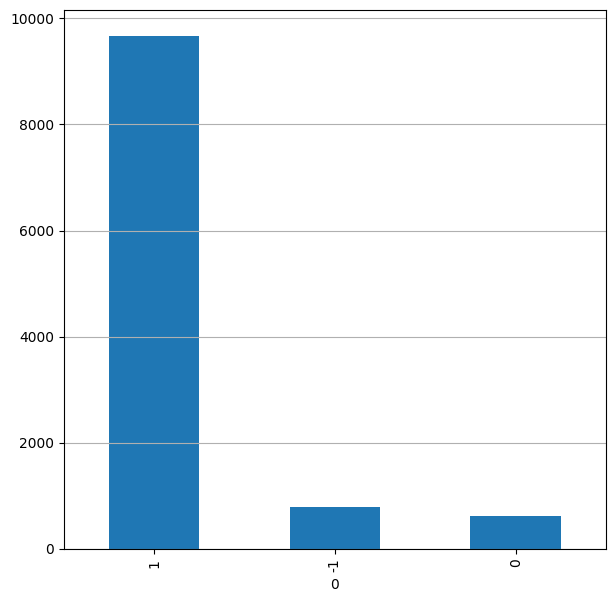

In [87]:
pd.DataFrame(labels)[0].value_counts().plot.bar(figsize=(7, 7))
plt.grid(axis='y')

Данные не сбалансированы. Оно и понятно. Если фильм отличный, то большинство оценок будут положительными. Наверное, сбалансированные оценки какого-нибудь фильма большая редкость, поскольку фильм может быть либо отличным либо плохим. Средний фильм, скорее всего, будет оценен как плохой, если вообще будет оценен.

#### Часть 2. NLP

##### 2.1. Стоп-слова, нижний регистр, леммитизация

In [89]:
import nltk

In [90]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MVKiselev\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [91]:
len(stop_words)

179

In [92]:
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [93]:
word_tokenizer = nltk.WordPunctTokenizer()

In [100]:
texts_lower = [x.lower() for x in data]

In [101]:
len(texts_lower)

11077

In [114]:
texts_lower[1]

"it is no wonder that the film has such a high rating, it is quite literally breathtaking. what can i say that hasn't said before? not much, it's the story, the acting, the premise, but most of all, this movie is about how it makes you feel. sometimes you watch a film, and can't remember it days later, this film loves with you, once you've seen it, you don't forget.\n\nthe ultimate story of friendship, of hope, and of life, and overcoming adversity.\n\ni understand why so many class this as the best film of all time, it isn't mine, but i get it. if you haven't seen it, or haven't seen it for some time, you need to watch it, it's amazing. 10/10."

In [115]:
texts_lower_tokenized = []
for item in texts_lower:
        tokens = word_tokenizer.tokenize(item)
        tokens = [word for word in tokens if (word not in stop_words and not word.isnumeric())]
        texts_lower_tokenized.append(tokens)

In [116]:
len(texts_lower_tokenized)

11077

In [117]:
texts_lower_tokenized[1]

['wonder',
 'film',
 'high',
 'rating',
 ',',
 'quite',
 'literally',
 'breathtaking',
 '.',
 'say',
 "'",
 'said',
 '?',
 'much',
 ',',
 "'",
 'story',
 ',',
 'acting',
 ',',
 'premise',
 ',',
 ',',
 'movie',
 'makes',
 'feel',
 '.',
 'sometimes',
 'watch',
 'film',
 ',',
 "'",
 'remember',
 'days',
 'later',
 ',',
 'film',
 'loves',
 ',',
 "'",
 'seen',
 ',',
 "'",
 'forget',
 '.',
 'ultimate',
 'story',
 'friendship',
 ',',
 'hope',
 ',',
 'life',
 ',',
 'overcoming',
 'adversity',
 '.',
 'understand',
 'many',
 'class',
 'best',
 'film',
 'time',
 ',',
 "'",
 'mine',
 ',',
 'get',
 '.',
 "'",
 'seen',
 ',',
 "'",
 'seen',
 'time',
 ',',
 'need',
 'watch',
 ',',
 "'",
 'amazing',
 '.',
 '/',
 '.']

In [108]:
from nltk.stem.snowball import SnowballStemmer

In [109]:
stemmer = SnowballStemmer("english")

In [118]:
texts = []
for i in range(len(texts_lower_tokenized)):
    text_lemmatized = [SnowballStemmer("english").stem(x) for x in texts_lower_tokenized[i]]
    texts.append(text_lemmatized)

In [119]:
len(texts)

11077

In [120]:
texts[1][:20]

['wonder',
 'film',
 'high',
 'rate',
 ',',
 'quit',
 'liter',
 'breathtak',
 '.',
 'say',
 "'",
 'said',
 '?',
 'much',
 ',',
 "'",
 'stori',
 ',',
 'act',
 ',']

##### 2.2. tf-idf преобразование

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [124]:
train_texts, test_texts, train_y, test_y = train_test_split(data, labels, test_size=0.2, random_state=42, stratify = labels)

In [125]:
vectorizer = TfidfVectorizer(max_features = 500, norm = None, lowercase=True, stop_words=stop_words)
vectorizer.fit(train_texts)

TfidfVectorizer(max_features=500, norm=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [126]:
vectorizer.get_feature_names_out()[:10]

array(['10', '100', '1994', '20', '250', 'ability', 'able', 'absolutely',
       'academy', 'acting'], dtype=object)

In [127]:
train_X = vectorizer.fit_transform(train_texts)
test_X  = vectorizer.transform(test_texts)

##### 2.3. Построение модели

In [129]:
from sklearn.ensemble import RandomForestClassifier

In [130]:
clf = RandomForestClassifier(n_estimators = 500, max_depth = 10)
clf = clf.fit(train_X, train_y)

pred = clf.predict(test_X)

In [131]:
print('Предсказанные метки: ', pred[0:20], ".....")
print('Истинные метки: ', test_y[0:20], ".....")

Предсказанные метки:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] .....
Истинные метки:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1] .....


In [132]:
from sklearn.metrics import accuracy_score, f1_score

In [133]:
print('Accuracy: ', accuracy_score(test_y, pred))
print('F1: ', f1_score(test_y, pred, average = 'macro'))

Accuracy:  0.8731949458483754
F1:  0.31076848952059744
